In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
data = np.load("pymdata.pkl", allow_pickle=True)
data.keys()

dict_keys(['sx', 'sy', 'flux'])

In [38]:
sx = np.asarray(data["sx"])
sy = np.asarray(data["sy"])
flux = np.asarray(data["flux"])

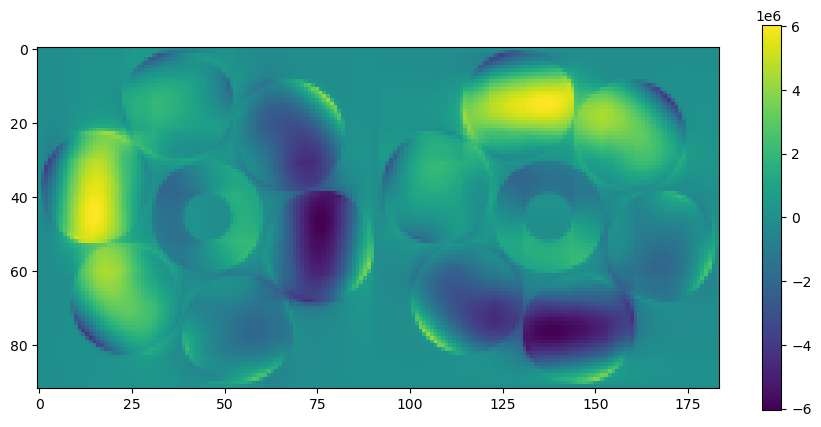

In [39]:
fig,ax = plt.subplots(figsize=(11,5))
h = ax.imshow(np.hstack([x.reshape(92,-1) for x in [sx,sy]]))
fig.colorbar(h,ax=ax)

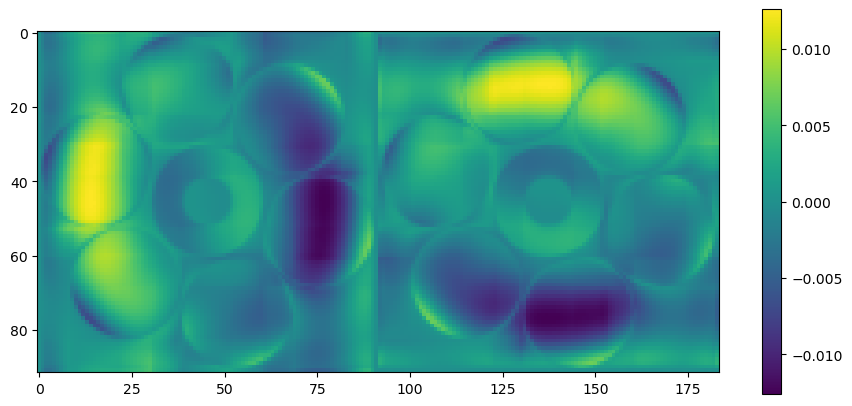

In [40]:
fig,ax = plt.subplots(figsize=(11,5))
h = ax.imshow(np.hstack([x.reshape(92,-1) for x in [sx/flux,sy/flux]]))
fig.colorbar(h,ax=ax)

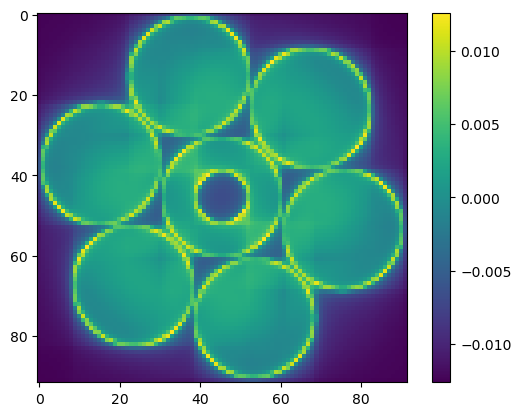

In [41]:
fig,ax = plt.subplots()
ax.imshow(flux.reshape(-1,92))
fig.colorbar(h,ax=ax)

In [17]:
data = np.load("pymtor.pkl", allow_pickle=True)
data.keys()

dict_keys(['n_mode', 'segments', 'piston_mask', 'h_filter', 'p_filter', 'offset', 'h_matrix', 'p_matrix', 'estimator'])

In [5]:
n = 92
n_mode = 450

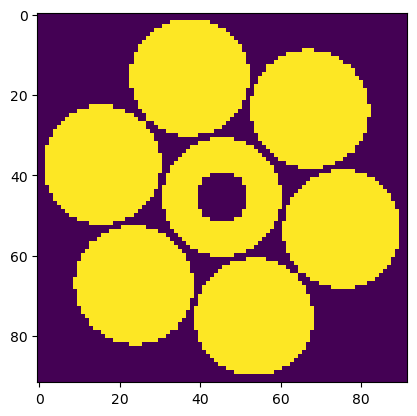

In [6]:
h_filter = np.asarray(data["h_filter"]).reshape(n,n)
fig, ax = plt.subplots()
ax.imshow(h_filter)

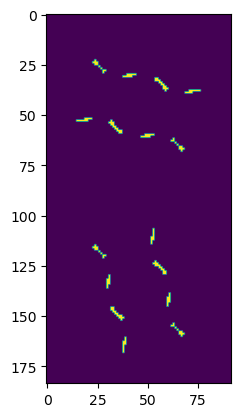

In [7]:
p_filter = np.asarray(data["p_filter"]).reshape(-1,n)
fig, ax = plt.subplots()
ax.imshow(p_filter)

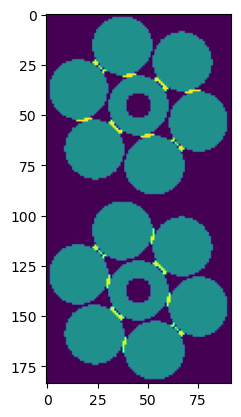

In [24]:
mask = np.asarray(data["h_filter"])
p_mask = np.asarray(data["p_filter"])*2
p_mask[:n*n][mask] = 1
p_mask[n*n:][mask] = 1
fig, ax = plt.subplots()
ax.imshow(p_mask.reshape(-1,n))

In [8]:
H_rs = np.asarray(data["h_matrix"][0]).reshape(data["h_matrix"][2],data["h_matrix"][1]).T
np.linalg.cond(H_rs),np.linalg.matrix_rank(H_rs),H_rs.shape

(39.8445236670513, 3149, (9264, 3149))

In [9]:
P_rs = np.asarray(data["p_matrix"][0]).reshape(data["p_matrix"][2],data["p_matrix"][1]).T
np.linalg.cond(P_rs),np.linalg.matrix_rank(P_rs),P_rs.shape

(31.399886658327382, 184, (184, 3149))

In [10]:
M = np.vstack([H_rs,P_rs])
Q = M.T @ M
Mpinv = np.linalg.inv(Q) @ M.T 
A = np.eye(7*n_mode)
A = np.delete(A,6*n_mode,axis=0)
for i in range(6):
    A[i*n_mode,6*n_mode] = -1
Mp = M @ A
a = np.zeros((n_mode,1))
a[0] = 1
a = np.kron(np.ones((7,1)),a)
C = np.vstack([\
            np.hstack([np.zeros((n_mode*7,n_mode*7)),Mp.T,a]),\
            np.hstack([Mp,np.eye(Mp.shape[0]),np.zeros((Mp.shape[0],1))]),\
            np.hstack([a.T,np.zeros((1,Mp.shape[0]+1))])   
                ])

In [11]:
uC,sC,vC_t = np.linalg.svd(C)

In [13]:
iCred = vC_t[:,:7*n_mode].T @ np.diag(1./sC) @ uC[7*n_mode:7*n_mode+Mpinv.shape[1],:].T
iCred.shape

(3150, 9448)

In [14]:
import pickle
data = (iCred.ravel("F").tolist(),iCred.shape[0],iCred.shape[1])
with open("pym_constrained_recon.pkl","wb") as f:
    pickle.dump(data,f)

In [74]:
np.linalg.norm(Mp)/np.sqrt(Mp.size)

2835361.2918309686

In [94]:
Ca = np.vstack([Mp,1e3*a.T])
uCa,sCa,vCa_t = np.linalg.svd(Ca,full_matrices=False)

In [97]:
iCared = vCa_t.T @ np.diag(1./sCa) @ uCa[:Mpinv.shape[1],:].T
iCared.shape

(3150, 9416)

In [98]:
import pickle
data = (iCred.ravel("F").tolist(),iCred.shape[0],iCred.shape[1])
with open("pym_constrained_recon_approx.pkl","wb") as f:
    pickle.dump(data,f)